
# Linear Regression — Hyperparameter Tuning & Diagnostics (Visual Guide)

This notebook builds a synthetic regression dataset with **nonlinear signal + noise** and visualizes how
**ordinary least squares (OLS)** and its regularized variants (**Ridge, Lasso, Elastic Net**) behave as you change hyperparameters.
We also explore **polynomial feature expansion** to model curvature.

What you'll see:
- Baseline **OLS**
- **Ridge**: α sweep with coefficient shrinkage & fit quality
- **Lasso**: α sweep with sparsity & fit quality
- **Elastic Net**: grid over α and `l1_ratio`
- **PolynomialFeatures** (degree 1–5) with Ridge to control overfitting
- **Validation curves** (train/test) and **residual diagnostics** (residuals vs fitted; QQ plot)
- **Learning curve** by subsampling


In [10]:

import numpy as np
import matplotlib.pyplot as plt, warnings
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

np.random.seed(123)
warnings.filterwarnings("ignore")

# Synthetic 1D -> y with curvature + noise
n = 200
X = np.linspace(-3, 3, n).reshape(-1, 1)
y_true = 2.0 * np.sin(1.2*X).ravel() + 0.5*X.ravel()  # nonlinear signal
eps = np.random.normal(0, 2.0, size=n)
y = y_true + eps

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

def metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    return mse, rmse, mae, r2

def scatter_with_fit(X_tr, y_tr, X_te, y_te, yhat_tr, yhat_te, title):
    plt.figure(figsize=(7,4.5))
    plt.scatter(X_tr.ravel(), y_tr, s=12, alpha=0.7, label="train")
    plt.scatter(X_te.ravel(), y_te, s=16, alpha=0.9, marker="x", label="test")
    # Smooth fit line on a dense grid
    xx = np.linspace(X.min(), X.max(), 600).reshape(-1,1)
    yy = model.predict(xx)  # model must be in outer scope where used
    plt.plot(xx.ravel(), yy, linewidth=2)
    mtr, rtr, atr, r2tr = metrics(y_tr, yhat_tr)
    mte, rte, ate, r2te = metrics(y_te, yhat_te)
    plt.title(f"{title}")
    print(f"{title}\ntrain RMSE={rtr:.3f}, R2={r2tr:.3f} | test RMSE={rte:.3f}, R2={r2te:.3f}")
    plt.xlabel("x"); plt.ylabel("y"); plt.legend()
    plt.tight_layout(); plt.show()


## 1) Baseline: Ordinary Least Squares (degree=1)

OLS (degree=1)
train RMSE=2.433, R2=0.247 | test RMSE=2.358, R2=0.347


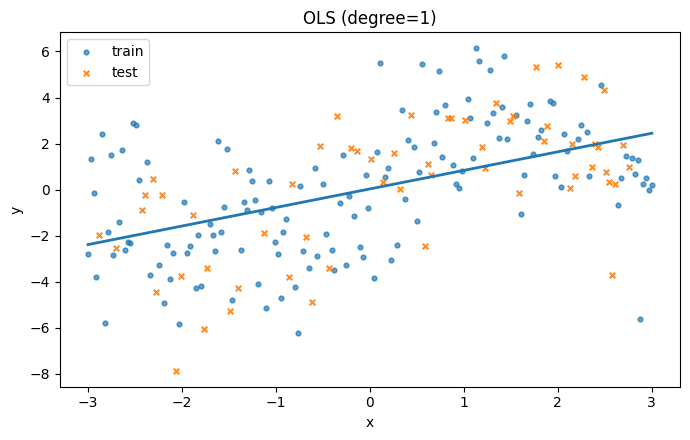

In [11]:

model = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=1, include_bias=False)),
    ("lr", LinearRegression())
])
model.fit(X_train, y_train)
yhat_tr = model.predict(X_train)
yhat_te = model.predict(X_test)
scatter_with_fit(X_train, y_train, X_test, y_test, yhat_tr, yhat_te, "OLS (degree=1)")


## 2) Ridge Regression — α sweep

Ridge (degree=3), alpha=0.01
train RMSE=2.119, R2=0.429 | test RMSE=2.079, R2=0.493


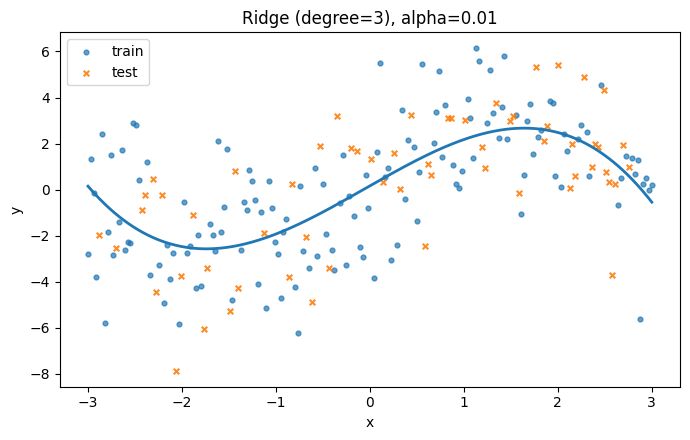

Ridge (degree=3), alpha=0.1
train RMSE=2.119, R2=0.429 | test RMSE=2.079, R2=0.493


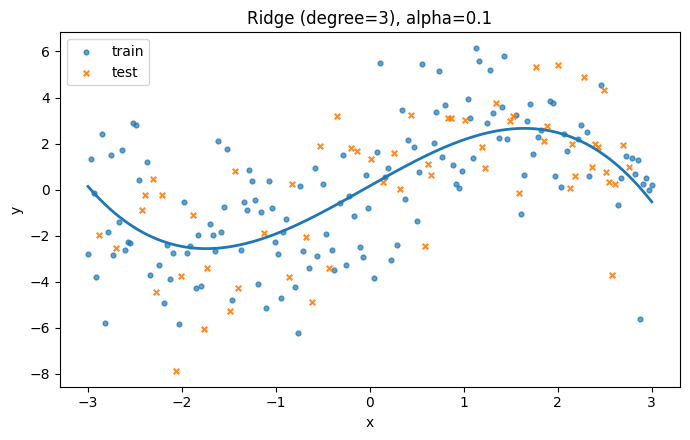

Ridge (degree=3), alpha=1.0
train RMSE=2.120, R2=0.428 | test RMSE=2.086, R2=0.489


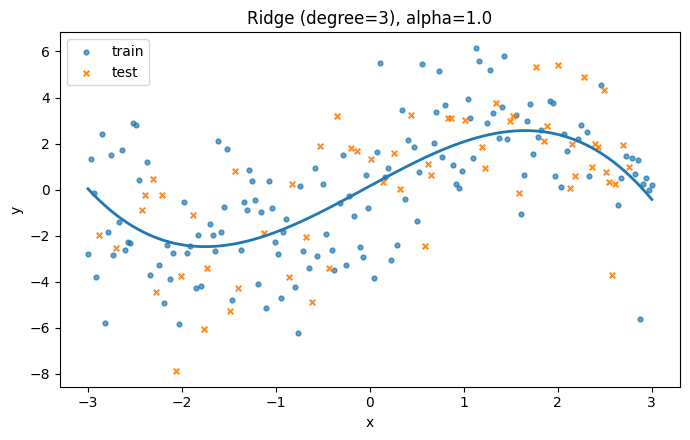

Ridge (degree=3), alpha=10.0
train RMSE=2.185, R2=0.393 | test RMSE=2.175, R2=0.445


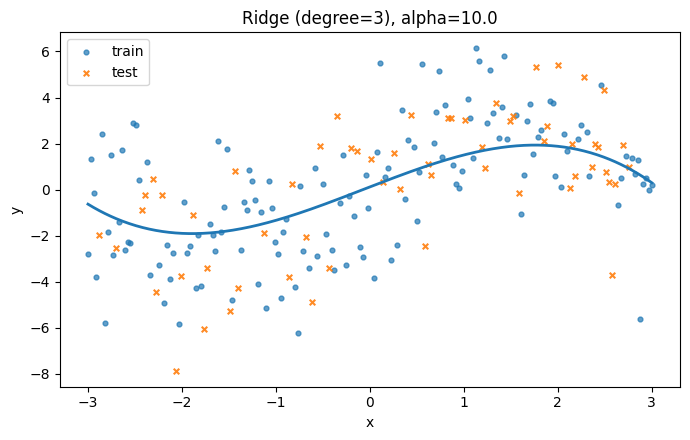

Ridge (degree=3), alpha=100.0
train RMSE=2.506, R2=0.201 | test RMSE=2.516, R2=0.257


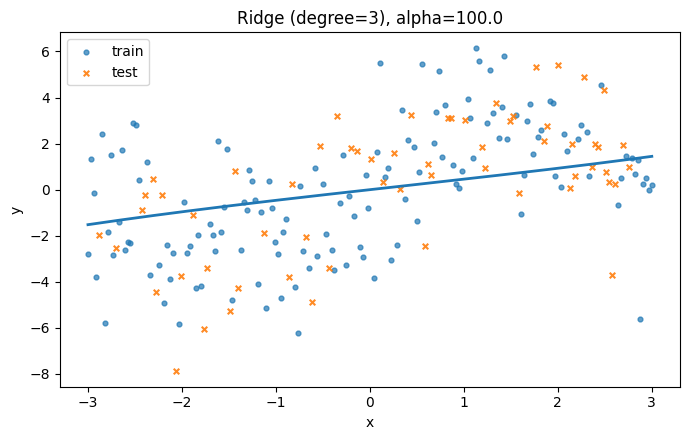

In [12]:

for a in [0.01, 0.1, 1.0, 10.0, 100.0]:
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree=3, include_bias=False)),  # allow curvature
        ("ridge", Ridge(alpha=a, random_state=123))
    ])
    model.fit(X_train, y_train)
    yhat_tr = model.predict(X_train)
    yhat_te = model.predict(X_test)
    scatter_with_fit(X_train, y_train, X_test, y_test, yhat_tr, yhat_te,
                     f"Ridge (degree=3), alpha={a}")


## 3) Lasso Regression — α sweep

Lasso (degree=5), alpha=0.001
train RMSE=2.081, R2=0.449 | test RMSE=2.126, R2=0.469


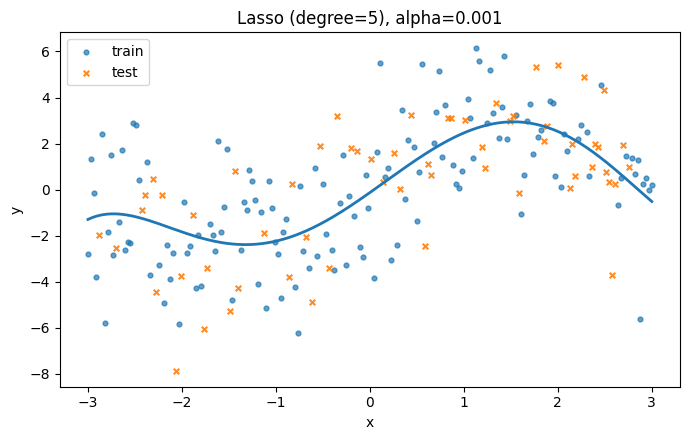

Lasso (degree=5), alpha=0.01
train RMSE=2.086, R2=0.447 | test RMSE=2.113, R2=0.476


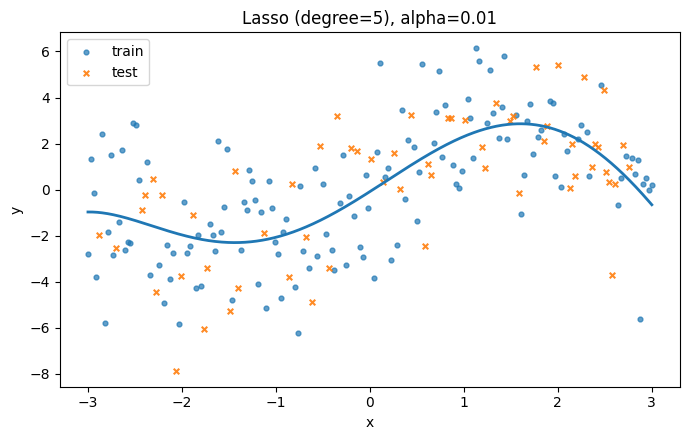

Lasso (degree=5), alpha=0.1
train RMSE=2.167, R2=0.403 | test RMSE=2.129, R2=0.468


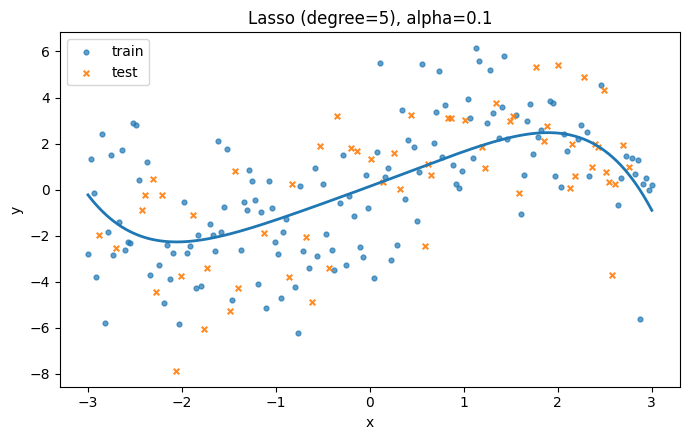

Lasso (degree=5), alpha=1.0
train RMSE=2.630, R2=0.120 | test RMSE=2.706, R2=0.140


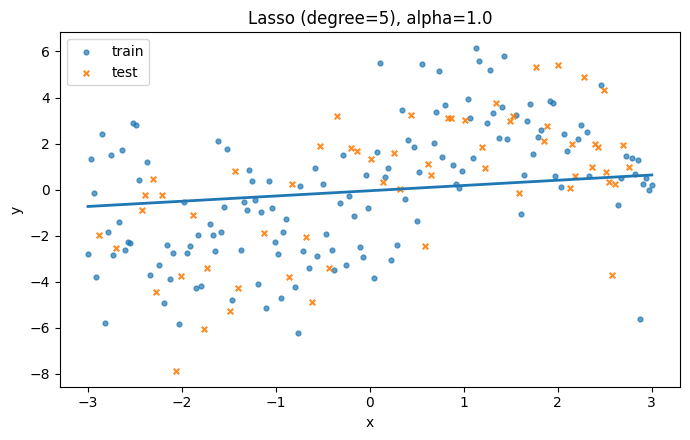

In [13]:

for a in [0.001, 0.01, 0.1, 1.0]:
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree=5, include_bias=False)),  # richer basis
        ("lasso", Lasso(alpha=a, max_iter=10000, random_state=123))
    ])
    model.fit(X_train, y_train)
    yhat_tr = model.predict(X_train)
    yhat_te = model.predict(X_test)
    scatter_with_fit(X_train, y_train, X_test, y_test, yhat_tr, yhat_te,
                     f"Lasso (degree=5), alpha={a}")


## 4) Elastic Net — grid over α and l1_ratio

ElasticNet (deg=5) α=0.01, l1_ratio=0.2
train RMSE=2.095, R2=0.442 | test RMSE=2.119, R2=0.473


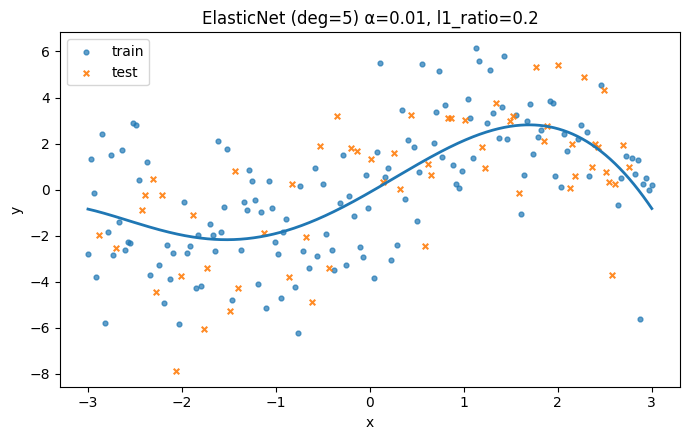

ElasticNet (deg=5) α=0.01, l1_ratio=0.5
train RMSE=2.091, R2=0.444 | test RMSE=2.116, R2=0.474


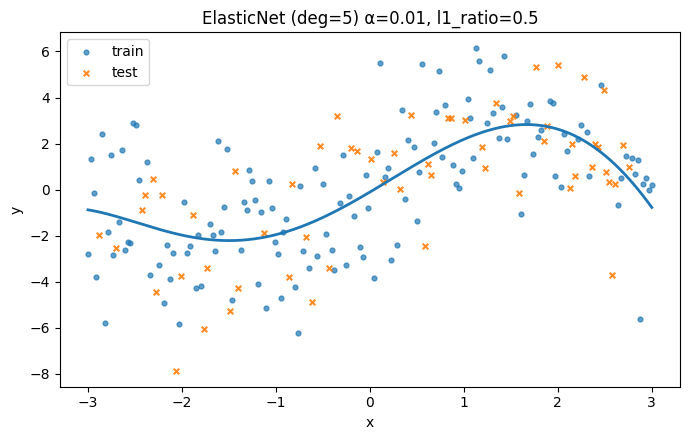

ElasticNet (deg=5) α=0.01, l1_ratio=0.8
train RMSE=2.088, R2=0.445 | test RMSE=2.114, R2=0.476


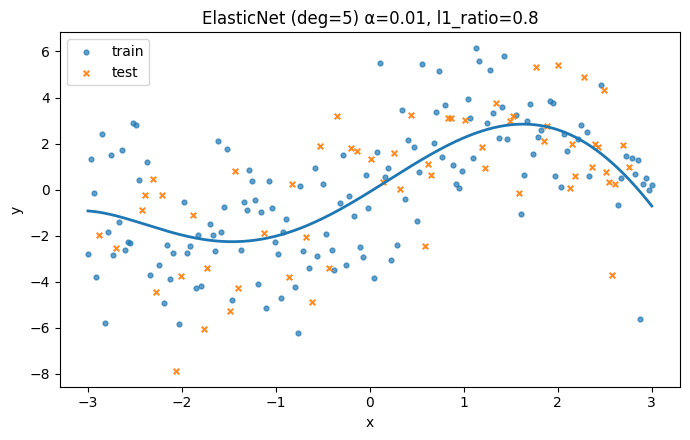

ElasticNet (deg=5) α=0.1, l1_ratio=0.2
train RMSE=2.186, R2=0.392 | test RMSE=2.174, R2=0.445


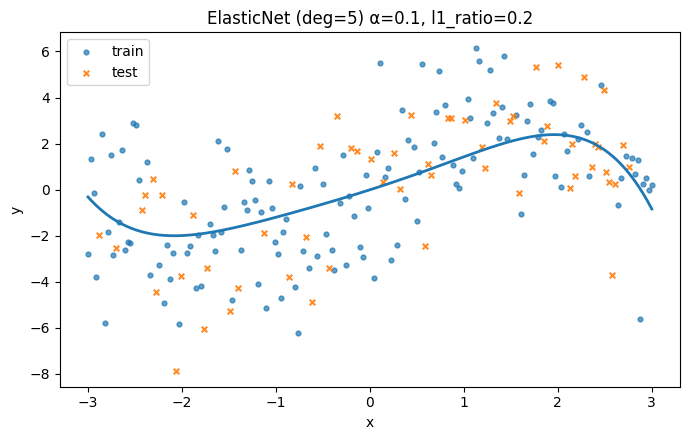

ElasticNet (deg=5) α=0.1, l1_ratio=0.5
train RMSE=2.177, R2=0.397 | test RMSE=2.152, R2=0.456


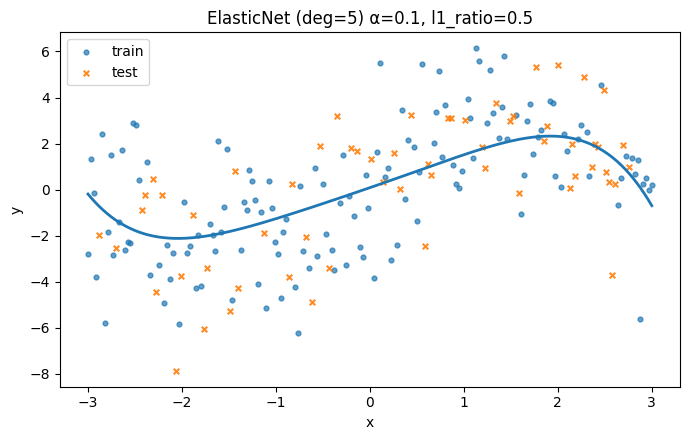

ElasticNet (deg=5) α=0.1, l1_ratio=0.8
train RMSE=2.171, R2=0.401 | test RMSE=2.138, R2=0.463


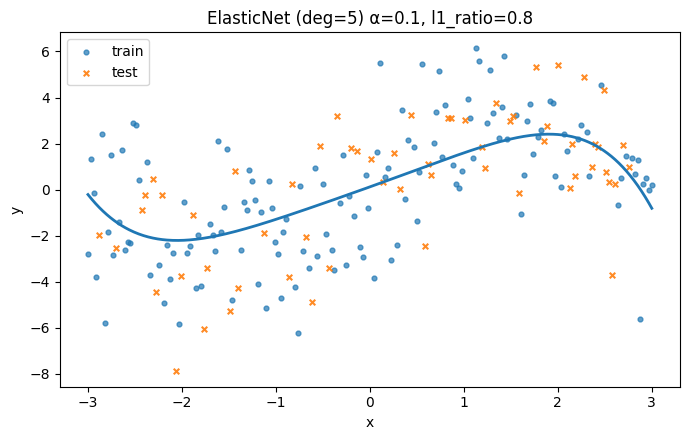

ElasticNet (deg=5) α=1.0, l1_ratio=0.2
train RMSE=2.513, R2=0.196 | test RMSE=2.544, R2=0.240


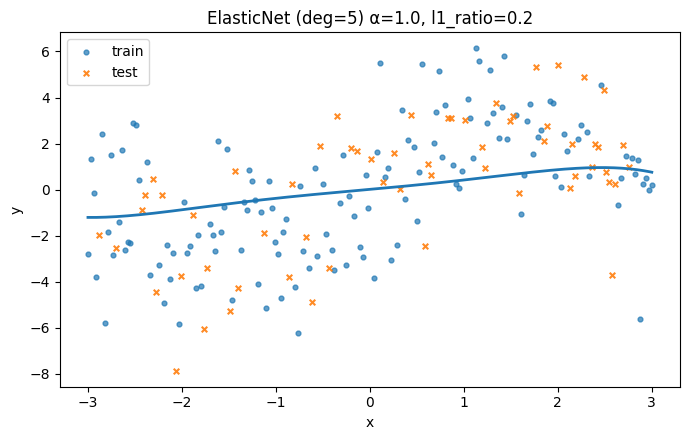

ElasticNet (deg=5) α=1.0, l1_ratio=0.5
train RMSE=2.560, R2=0.166 | test RMSE=2.607, R2=0.202


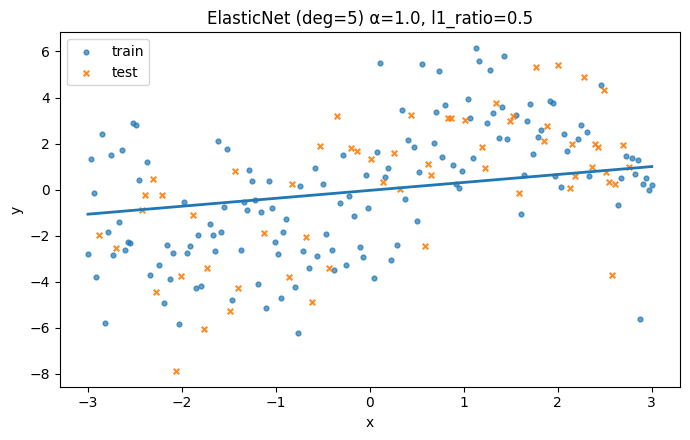

ElasticNet (deg=5) α=1.0, l1_ratio=0.8
train RMSE=2.593, R2=0.144 | test RMSE=2.655, R2=0.173


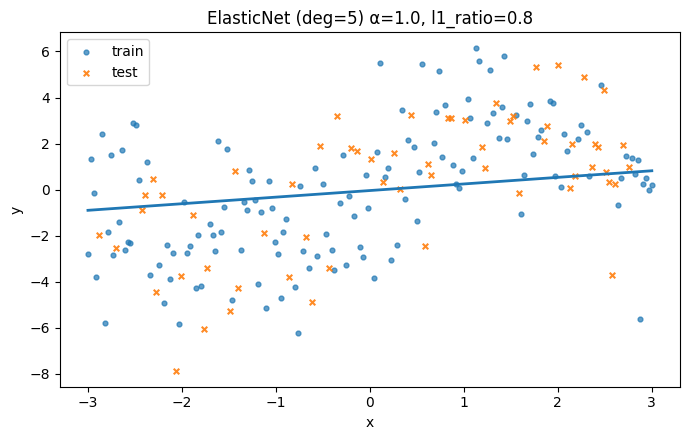

In [14]:

for a in [0.01, 0.1, 1.0]:
    for r in [0.2, 0.5, 0.8]:
        model = Pipeline([
            ("scaler", StandardScaler()),
            ("poly", PolynomialFeatures(degree=5, include_bias=False)),
            ("enet", ElasticNet(alpha=a, l1_ratio=r, max_iter=10000, random_state=123))
        ])
        model.fit(X_train, y_train)
        yhat_tr = model.predict(X_train)
        yhat_te = model.predict(X_test)
        scatter_with_fit(X_train, y_train, X_test, y_test, yhat_tr, yhat_te,
                         f"ElasticNet (deg=5) α={a}, l1_ratio={r}")


## 5) Polynomial degree sweep (with Ridge α=1.0)

Ridge α=1.0 with Polynomial degree=1
train RMSE=2.433, R2=0.247 | test RMSE=2.360, R2=0.346


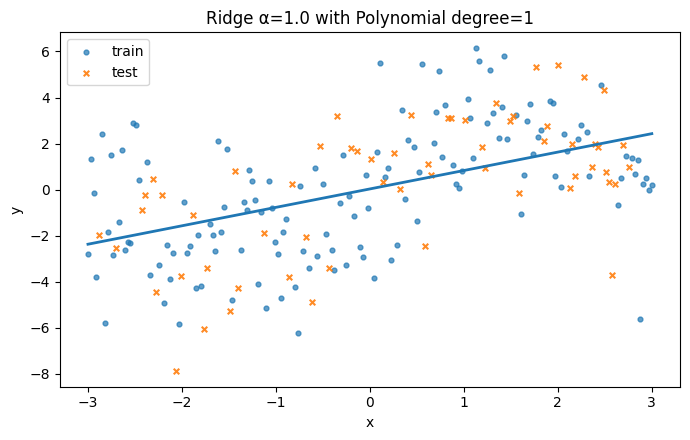

Ridge α=1.0 with Polynomial degree=2
train RMSE=2.431, R2=0.248 | test RMSE=2.350, R2=0.352


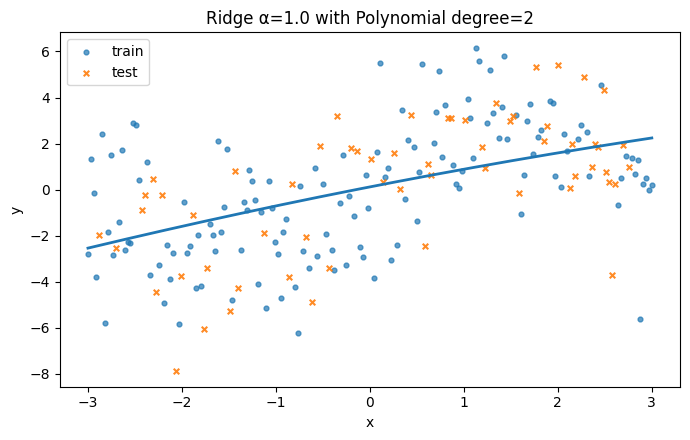

Ridge α=1.0 with Polynomial degree=3
train RMSE=2.120, R2=0.428 | test RMSE=2.086, R2=0.489


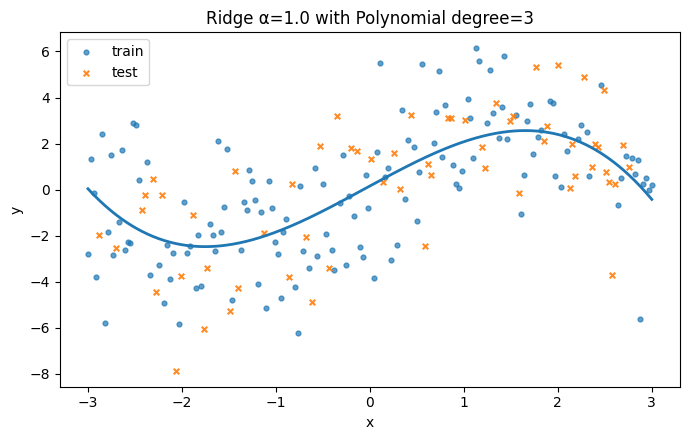

Ridge α=1.0 with Polynomial degree=4
train RMSE=2.102, R2=0.438 | test RMSE=2.119, R2=0.473


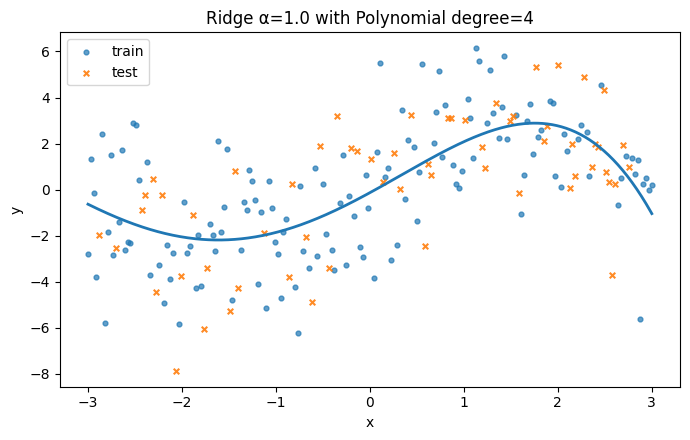

Ridge α=1.0 with Polynomial degree=5
train RMSE=2.091, R2=0.444 | test RMSE=2.119, R2=0.473


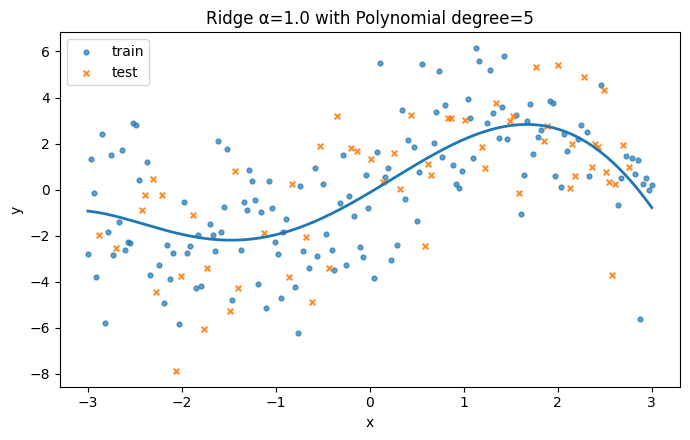

In [15]:

for deg in [1, 2, 3, 4, 5]:
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree=deg, include_bias=False)),
        ("ridge", Ridge(alpha=1.0, random_state=123))
    ])
    model.fit(X_train, y_train)
    yhat_tr = model.predict(X_train)
    yhat_te = model.predict(X_test)
    scatter_with_fit(X_train, y_train, X_test, y_test, yhat_tr, yhat_te,
                     f"Ridge α=1.0 with Polynomial degree={deg}")


## 6) Validation curve — Ridge α vs error (train/test)

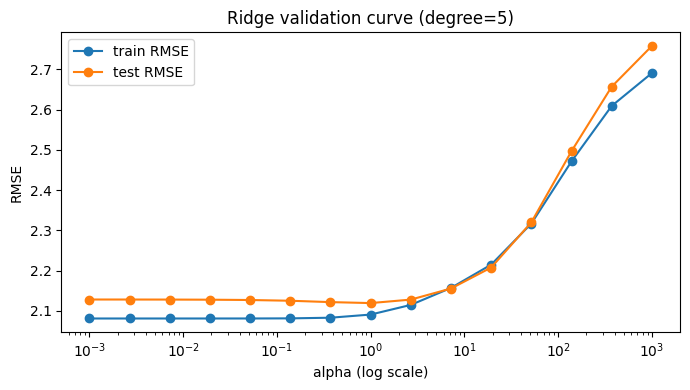

In [16]:

alphas = np.logspace(-3, 3, 15)
train_rmse, test_rmse = [], []

for a in alphas:
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree=5, include_bias=False)),
        ("ridge", Ridge(alpha=a, random_state=123))
    ])
    model.fit(X_train, y_train)
    yhat_tr = model.predict(X_train); yhat_te = model.predict(X_test)
    _, rtr, _, _ = metrics(y_train, yhat_tr)
    _, rte, _, _ = metrics(y_test,  yhat_te)
    train_rmse.append(rtr); test_rmse.append(rte)

plt.figure(figsize=(7,4))
plt.semilogx(alphas, train_rmse, marker="o", label="train RMSE")
plt.semilogx(alphas, test_rmse,  marker="o", label="test RMSE")
plt.xlabel("alpha (log scale)"); plt.ylabel("RMSE")
plt.title("Ridge validation curve (degree=5)")
plt.legend(); plt.tight_layout(); plt.show()


## 7) Residual diagnostics — residuals vs fitted and QQ-like check

Best alpha (by test RMSE): 1.0


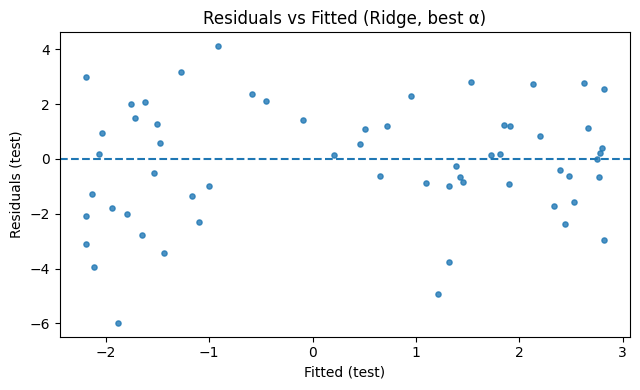

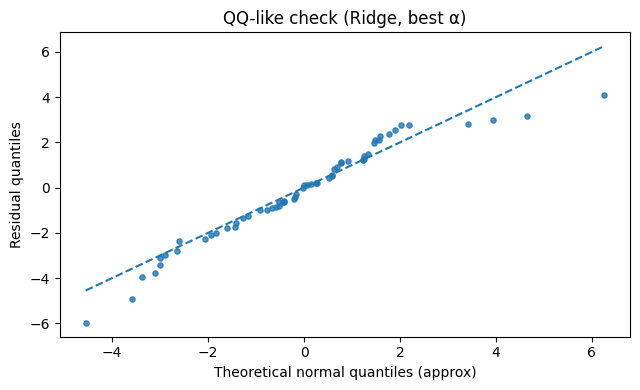

In [17]:

# Choose alpha with lowest test RMSE from previous cell
best_idx = int(np.argmin(test_rmse))
best_alpha = alphas[best_idx]
print("Best alpha (by test RMSE):", best_alpha)

model = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=5, include_bias=False)),
    ("ridge", Ridge(alpha=best_alpha, random_state=123))
])
model.fit(X_train, y_train)
yhat_te = model.predict(X_test)
res = y_test - yhat_te

# Residuals vs fitted
plt.figure(figsize=(6.5,4))
plt.scatter(yhat_te, res, s=14, alpha=0.8)
plt.axhline(0, linestyle="--")
plt.xlabel("Fitted (test)"); plt.ylabel("Residuals (test)")
plt.title("Residuals vs Fitted (Ridge, best α)")
plt.tight_layout(); plt.show()

# QQ-like: compare sorted residuals to sorted normal samples with same std
res_std = np.std(res)
qq_ref = np.sort(np.random.normal(0, res_std, size=len(res)))
plt.figure(figsize=(6.5,4))
plt.scatter(np.sort(qq_ref), np.sort(res), s=14, alpha=0.8)
plt.plot([qq_ref.min(), qq_ref.max()], [qq_ref.min(), qq_ref.max()], linestyle="--")
plt.xlabel("Theoretical normal quantiles (approx)")
plt.ylabel("Residual quantiles")
plt.title("QQ-like check (Ridge, best α)")
plt.tight_layout(); plt.show()


## 8) Learning curve — sample size vs test RMSE (Ridge α=best)

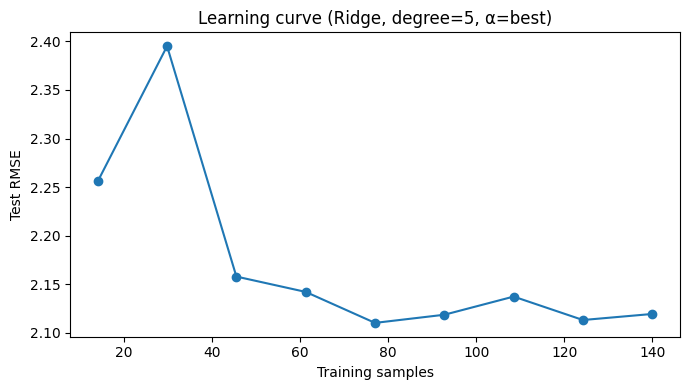

In [18]:

sizes = np.linspace(0.1, 1.0, 9)
rmse_te = []
for s in sizes:
    m = int(len(X_train) * s)
    idx = np.random.choice(len(X_train), size=m, replace=False)
    Xs, ys = X_train[idx], y_train[idx]
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree=5, include_bias=False)),
        ("ridge", Ridge(alpha=best_alpha, random_state=123))
    ])
    model.fit(Xs, ys)
    yhat = model.predict(X_test)
    _, rte, _, _ = metrics(y_test, yhat)
    rmse_te.append(rte)

plt.figure(figsize=(7,4))
plt.plot(sizes*len(X_train), rmse_te, marker="o")
plt.xlabel("Training samples"); plt.ylabel("Test RMSE")
plt.title("Learning curve (Ridge, degree=5, α=best)")
plt.tight_layout(); plt.show()
